In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)

2023-03-02 21:59:37.907139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 21:59:38.432116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-02 21:59:38.432209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-02 21:59:38.432217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [2]:
True if(len(tf.config.list_physical_devices('GPU')) > 0) else False

2023-03-02 21:59:41.018499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


True

2023-03-02 21:59:41.023637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 21:59:41.023692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

In [4]:
print("Multivariate Sample")
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/energy_dataset.csv"
df = load_data(data_path, col=["time","total load forecast","total load actual"])

Multivariate Sample


In [5]:
df

,time,total load forecast,total load actual
0,2015-01-01 00:00:00+01:00,26118.0,25385.0
1,2015-01-01 01:00:00+01:00,24934.0,24382.0
2,2015-01-01 02:00:00+01:00,23515.0,22734.0
3,2015-01-01 03:00:00+01:00,22642.0,21286.0
4,2015-01-01 04:00:00+01:00,21785.0,20264.0
...,...,...,...
35059,2018-12-31 19:00:00+01:00,30619.0,30653.0
35060,2018-12-31 20:00:00+01:00,29932.0,29735.0
35061,2018-12-31 21:00:00+01:00,27903.0,28071.0
35062,2018-12-31 22:00:00+01:00,25450.0,25801.0


In [ ]:
df_filled = df.interpolate("linear")
mm = MinMaxScaler()
df_scaled = mm.fit_transform(df_filled)

In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [7]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

In [8]:
def split_data(series, train_fraq, test_len=8760):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data

In [9]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    print(ds)
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds


In [19]:
def build_dataset(train_fraq=0.65, n_steps=24, n_horizon=1, batch_size=256, shuffle_buffer=500, expand_dims=False, multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(data_path, col=['time', 'total load actual', 'price actual'])
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
    else:
        data = load_data(col=['total load actual'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

In [20]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [21]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks = get_callbacks(model.name))

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [22]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 128)               460928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 480,536
Trainable params: 480,536
Non-trainable p

In [23]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

In [24]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

In [25]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [26]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1984        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

In [27]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
# run_model("cnn", cnn_model, model_configs, epochs=150)
# run_model("lstm", lstm_model, model_configs, epochs=150)
# run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
# run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

<MapDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


<MapDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
      1/Unknown - 1s 1s/step - loss: 0.3576 - mae: 0.7148
Epoch 1: val_loss improved from inf to 0.12919, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 2s 460ms/step - loss: 0.4343 - mae: 0.8015 - val_loss: 0.1292 - val_mae: 0.4156
Epoch 2/150
1/3 [=========>....................] - ETA: 0s - loss: 0.2001 - mae: 0.5187
Epoch 2: val_loss improved from 0.12919 to 0.09662, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 380ms/step - loss: 0.1532 - mae: 0.4495 - val_loss: 0.0966 - val_mae: 0.3859
Epoch 3/150
1/3 [=========>....................] - ETA: 0s - loss: 0.1054 - mae: 0.3910
Epoch 3: val_loss improved from 0.09662 to 0.07440, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 377ms/step - loss: 0.0980 - mae: 0.3751 - val_loss: 0.0744 - val_mae: 0.3292
Epoch 4/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0942 - mae: 0.3647
Epoch 4: val_loss improved from 0.07440 to 0.06570, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 374ms/step - loss: 0.0886 - mae: 0.3519 - val_loss: 0.0657 - val_mae: 0.3143
Epoch 5/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0795 - mae: 0.3338
Epoch 5: val_loss improved from 0.06570 to 0.04425, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 386ms/step - loss: 0.0787 - mae: 0.3290 - val_loss: 0.0443 - val_mae: 0.2474
Epoch 6/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0725 - mae: 0.3100
Epoch 6: val_loss did not improve from 0.04425
3/3 [==============================] - 1s 147ms/step - loss: 0.0692 - mae: 0.3019 - val_loss: 0.0451 - val_mae: 0.2523
Epoch 7/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0636 - mae: 0.2915
Epoch 7: val_loss improved from 0.04425 to 0.03406, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 458ms/step - loss: 0.0600 - mae: 0.2826 - val_loss: 0.0341 - val_mae: 0.2121
Epoch 8/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - mae: 0.2577
Epoch 8: val_loss did not improve from 0.03406
3/3 [==============================] - 1s 137ms/step - loss: 0.0512 - mae: 0.2556 - val_loss: 0.0355 - val_mae: 0.2183
Epoch 9/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - mae: 0.2352
Epoch 9: val_loss improved from 0.03406 to 0.03164, saving model to saved_models/dnn
INFO:tensorflow:Assets written to: saved_models/dnn/assets


INFO:tensorflow:Assets written to: saved_models/dnn/assets


3/3 [==============================] - 1s 507ms/step - loss: 0.0438 - mae: 0.2381 - val_loss: 0.0316 - val_mae: 0.2095
Epoch 10/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - mae: 0.2282
Epoch 10: val_loss did not improve from 0.03164
3/3 [==============================] - 1s 138ms/step - loss: 0.0401 - mae: 0.2257 - val_loss: 0.0350 - val_mae: 0.2208
Epoch 11/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - mae: 0.2164
Epoch 11: val_loss did not improve from 0.03164
3/3 [==============================] - 1s 132ms/step - loss: 0.0361 - mae: 0.2140 - val_loss: 0.0345 - val_mae: 0.2192
Epoch 12/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - mae: 0.2095
Epoch 12: val_loss did not improve from 0.03164
3/3 [==============================] - 1s 132ms/step - loss: 0.0343 - mae: 0.2086 - val_loss: 0.0377 - val_mae: 0.2287
Epoch 13/150
1/3 [=========>....................] - ETA: 0s - loss: 0.0309 - mae: 0.1960
Epoch 13: val_loss did n

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


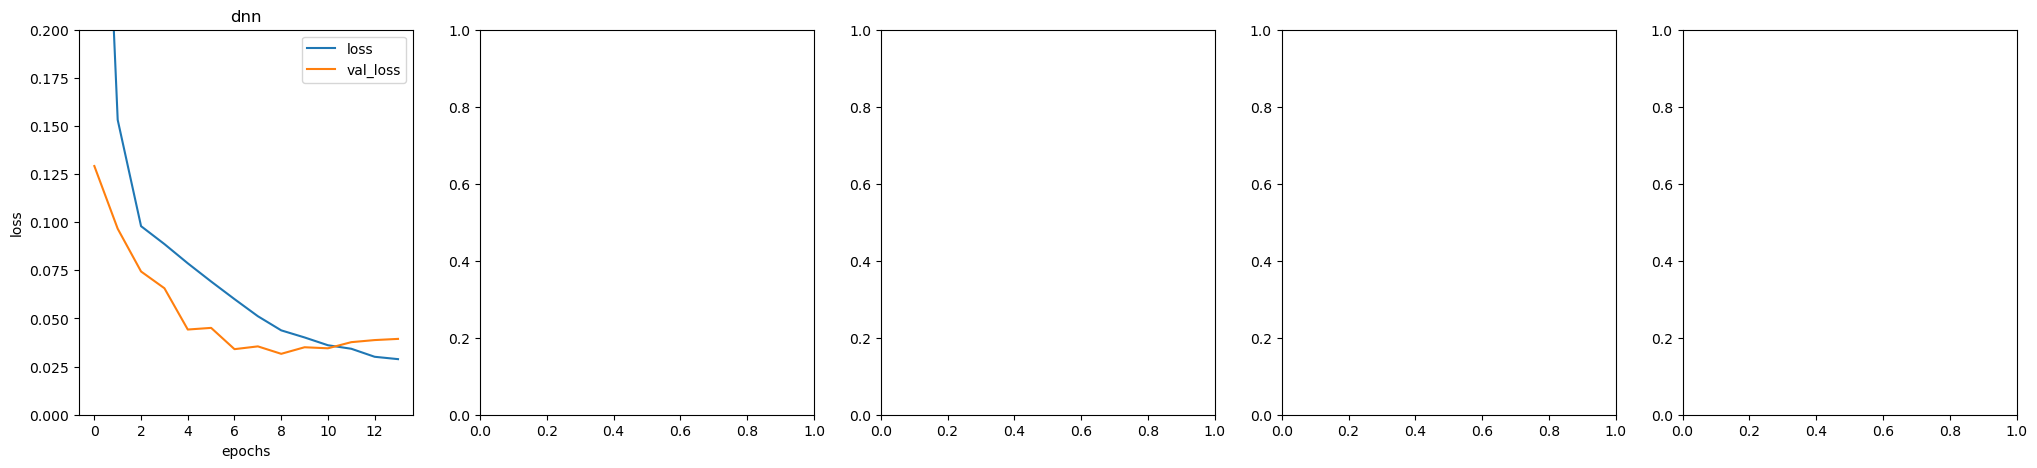

In [28]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


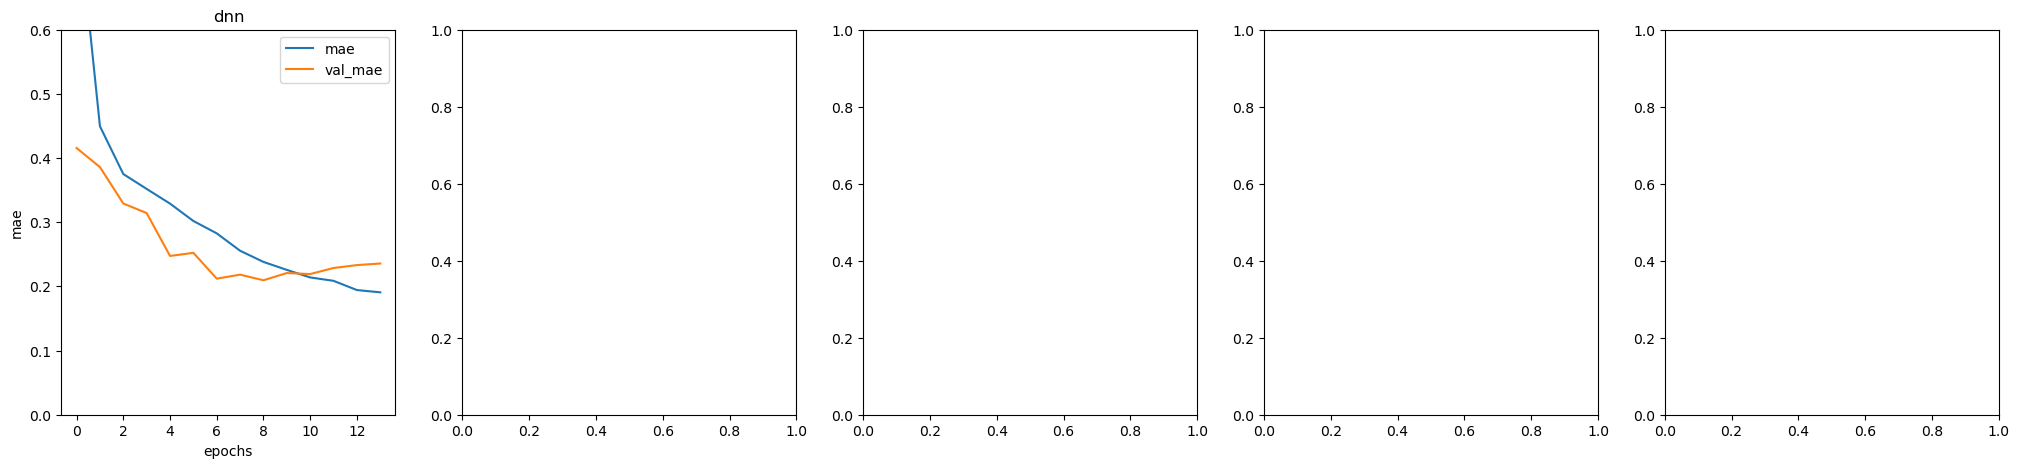

In [29]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [30]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['total load forecast'].mean()
print(performance_df) 

2/2 [==============================] - 0s 25ms/step - loss: 0.0258 - mae: 0.1771
          mae     error_mw
dnn  0.177061  5083.802906


2/2 [==============================] - 0s 20ms/step
First Two Weeks of Predictions


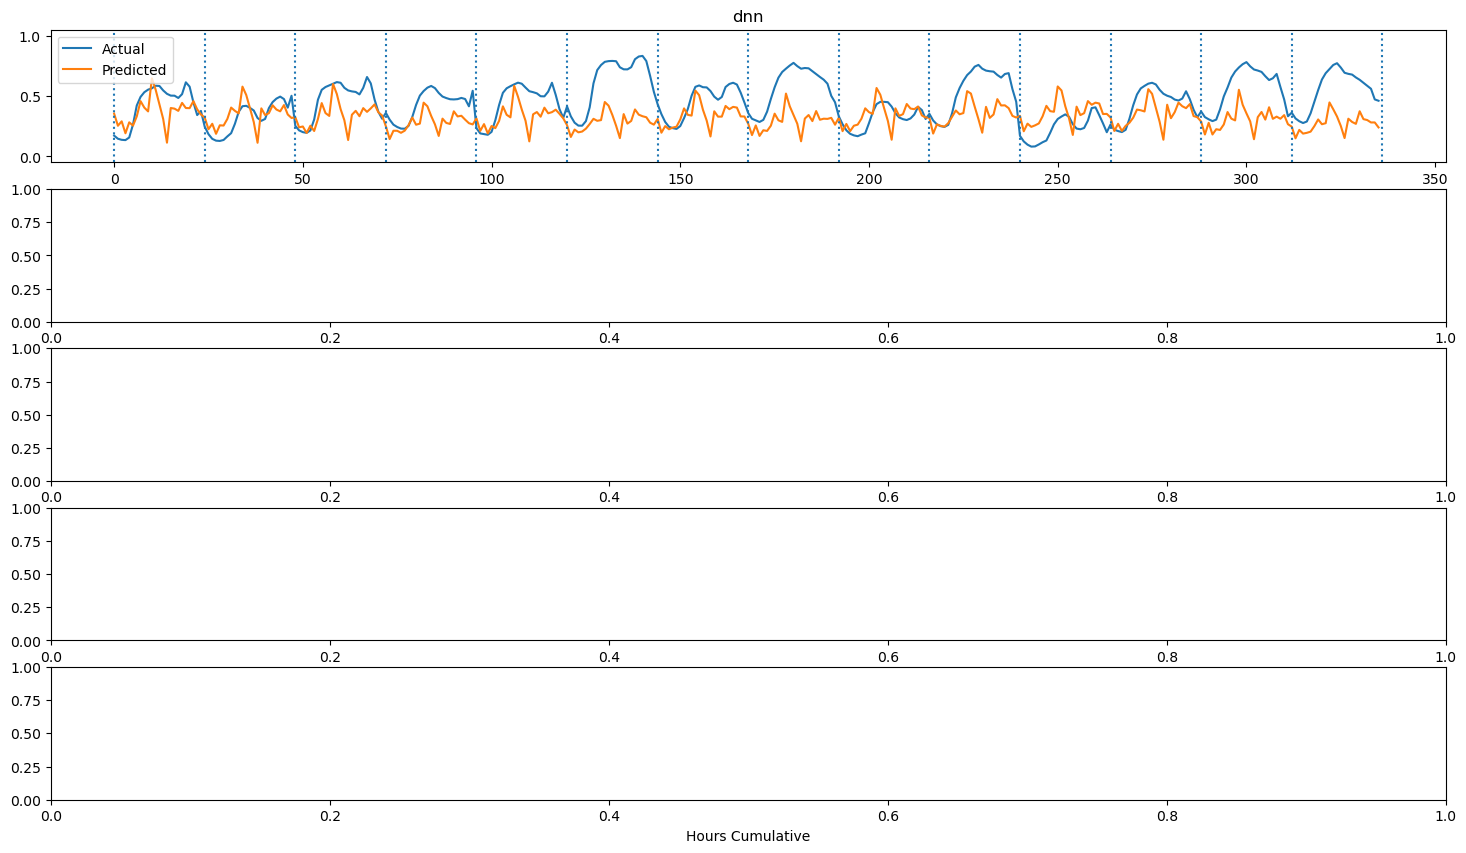

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')